In [377]:
import shap
import pickle
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
from tensorflow import keras 
import tensorflow as tf
import scipy.stats as st
from numpy import mean
from numpy import std
from tensorflow.keras.metrics import binary_accuracy
from sklearn.metrics import roc_auc_score, fbeta_score, recall_score, precision_score, accuracy_score
import seaborn as sns
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('seaborn-ticks')

In [2]:
!conda env export > environment.yml

In [378]:
#load train and test data

x_train = np.loadtxt('20210429_CRT_CCS_xtrain.txt')
x_test = np.loadtxt('20210429_CRT_CCS_xtest.txt')
y_train = np.loadtxt('20210429_CRT_CCS_ytrain.txt')
y_test = np.loadtxt('20210429_CRT_CCS_ytest.txt')
x_val = np.loadtxt('20210429_CRT_CCS_xval.txt')
y_val = np.loadtxt('20210429_CRT_CCS_yval.txt')


0.10002174385736029
0.17951728636660144
0.7204609697760382
33134
8256
4600


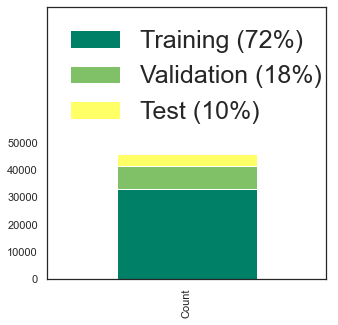

In [74]:
bar = []
barlabel = []
print(len(x_test)/(len(x_test)+len(x_val)+len(x_train)))
print(len(x_val)/(len(x_test)+len(x_val)+len(x_train)))
print(len(x_train)/(len(x_test)+len(x_val)+len(x_train)))

plt.rc('legend', fontsize=25)
    
barlabel.append("Training (72%)")
bar.append(len(x_train))

barlabel.append("Validation (18%)")
bar.append(len(x_val))

barlabel.append("Test (10%)")
bar.append(len(x_test))

print(len(x_train))

print(len(x_val))
print(len(x_test))



    
df = pd.DataFrame({'Count': bar}, index=barlabel)

#df.plot(kind='bar',stacked=True)
df.T.plot.bar(stacked=True, legend = False, figsize=(5,5), colormap='summer')
plt.legend(loc='upper left')
x = [0,10000,20000,30000,40000,50000,100000]
xt = [0,10000,20000,30000,40000,50000,""]
plt.yticks(x,xt)
plt.savefig('trainvaltestbargraphCCS.png', bbox_inches="tight")
plt.savefig('trainvaltestbargraphCCS.svg', bbox_inches="tight")
plt.show()

In [8]:
#load model
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()
mload = tf.keras.models.load_model('20210603_CCS_200epoch.model')

# #make predictions for whole dataset

allpredictions = mload.predict(np.asarray(x_test))

In [4]:
#Places an index and predictions in dataframe so the predictions can be sorted and the SHAP value for the top predictions can be obtained


alla1p=[]
alla2p=[]
alla8p=[]
allb8p=[]
allb17p=[]

for value in allpredictions:
    alla1p.append(value[0])
    #alla2p.append(value[1])
    #alla8p.append(value[2])
    #allb8p.append(value[3])
    #allb17p.append(value[4])

x_test1 = np.array(x_test)    
alla1p = np.array(alla1p)
#alla2p = np.array(alla2p)
#alla8p = np.array(alla8p)
#allb8p = np.array(allb8p)
#allb17p = np.array(allb17p)

alldatap = {'index': range(len(alla1p)),
        #'peptide': x_test1, 
        'A001': alla1p#, 
        #'A002': alla2p,
        #'A008': alla8p,
        #'B008': allb8p,
        #'B017': allb17p
           } 

alldfp = pd.DataFrame(alldatap) 

alldfp = alldfp.sort_values(by='A001', ascending=False)
alla001i = alldfp['index'].tolist()
#alldfp = alldfp.sort_values(by='A002', ascending=False)
#alla002i = alldfp['index'].tolist()
#alldfp = alldfp.sort_values(by='A008', ascending=False)
#alla008i = alldfp['index'].tolist()
#alldfp = alldfp.sort_values(by='B008', ascending=False)
#allb008i = alldfp['index'].tolist()
#alldfp = alldfp.sort_values(by='B017', ascending=False)
#allb017i = alldfp['index'].tolist()


i = 0


    

In [379]:
#Pick subset of data to use

# Full Dataset
x_testall = x_test
x_testsubset = x_test

datatrain = x_train


In [10]:
# Use training data as background, average it into 100 points
x_trainmeans = shap.kmeans(np.asarray(datatrain), 100)
explainer = shap.KernelExplainer(mload.predict, x_trainmeans)


In [9]:
#calculate shap values 
shap_values = explainer.shap_values(np.asarray(x_testsubset))
#save shap_values as temp file
with open("shapvaluestemp.pkl","wb") as f:
    pickle.dump(shap_values,f)

KeyboardInterrupt: 

In [9]:
# save shap_values, enter file name
with open("shapvaluesCCSall.pkl","wb") as f:
    pickle.dump(shap_values,f)



In [376]:
###Extract from file
with open("shapvaluesCCS.pkl","rb") as f:
    shap_valuesall = pickle.load(f)
    
shap_values = shap_valuesall


In [12]:
# transform the indexes to peptides with positions appended

char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

x_testpep = []
temppep = []
i = 0

while i < len(x_testsubset):
    j = 0
    while j < len(x_test[i]):
        temppep.append(str(char_index[int(x_testsubset[i][j])] + " " + str(j+1)))
        j+=1
    x_testpep.append(temppep)
    temppep = []
    i+=1


In [41]:
#split shap values and peptides into 8,9,10mers
print(x_testpep[0])
print(shap_values[0][0])

x_test8mers = []
x_test9mers = []
x_test10mers = []

x_testpep8mers = []
x_testpep9mers = []
x_testpep10mers = []

shap_values8mers = []
shap_values9mers = []
shap_values10mers = []

shap_values8mers.append([])
shap_values9mers.append([])
shap_values10mers.append([])

i = 0
while i < len(x_testpep):
    
    if 'END' in x_testpep[i][9]:
        if 'END' in x_testpep[i][8]:
                x_testpep8mers.append(x_testpep[i])
                shap_values8mers[0].append(shap_values[0][i])
                x_test8mers.append(x_test[i])
        else:
            x_testpep9mers.append(x_testpep[i])
            shap_values9mers[0].append(shap_values[0][i])
            x_test9mers.append(x_test[i])
    else:
        x_testpep10mers.append(x_testpep[i])
        shap_values10mers[0].append(shap_values[0][i])
        x_test10mers.append(x_test[i])
    i+=1
    
print(len(x_testpep))
print(len(x_testpep8mers)+len(x_testpep9mers)+len(x_testpep10mers))
print(shap_values8mers[0][0])

['H 1', 'L 2', 'D 3', 'R 4', 'P 5', 'V 6', 'F 7', 'L 8', 'R 9', 'END 10']
[ 23.67127138  -2.56203561  -5.31980607  16.0731339   -6.10508248
  -5.21163094  -0.93765125   1.30002845  26.64135744 -15.25197213]
4600
4600
[-1.83041559e+00 -1.67266715e-01 -6.85939680e+00 -3.84251028e-01
  6.32493696e+00 -1.95861768e+00 -1.94756778e-02  1.00755318e+01
 -1.55710548e+01 -1.99016723e+01]


In [83]:
#get the top number of shap values for plotting (toppercent)
with open("shapvaluesall.pkl","rb") as f:
    shap_values = pickle.load(f)
toppercent = 0.00135
shapvaluesallA001toppercent = []
shapvaluesallA002toppercent = []
shapvaluesallA008toppercent = []
shapvaluesallB008toppercent = []
shapvaluesallB017toppercent = [] 


i=0  
while i < 5:
    shapvaluesallA001toppercent.append([])
    shapvaluesallA002toppercent.append([])
    shapvaluesallA008toppercent.append([])
    shapvaluesallB008toppercent.append([])
    shapvaluesallB017toppercent.append([])
    

    j=0
    while j < int(len(x_test)*0.00135):
        shapvaluesallA001toppercent[i].append(shap_values[i][alla001i[j]]) 
        shapvaluesallA002toppercent[i].append(shap_values[i][alla002i[j]])  
        shapvaluesallA008toppercent[i].append(shap_values[i][alla008i[j]]) 
        shapvaluesallB008toppercent[i].append(shap_values[i][allb008i[j]])
        shapvaluesallB017toppercent[i].append(shap_values[i][allb017i[j]])

        j+=1
    i+=1
        
        
peptidesallA001toppercent = []
peptidesallA002toppercent = []
peptidesallA008toppercent = []
peptidesallB008toppercent = []
peptidesallB017toppercent = [] 


i=0
while i < int(len(x_test)*toppercent):
    peptidesallA001toppercent.append(x_test[alla001i[i]])
    peptidesallA002toppercent.append(x_test[alla002i[i]])
    peptidesallA008toppercent.append(x_test[alla008i[i]])
    peptidesallB008toppercent.append(x_test[allb008i[i]])
    peptidesallB017toppercent.append(x_test[allb017i[i]])
    i+=1
#save the shap values  
with open("shapvaluesallA001toppercent.pkl","wb") as f:
    pickle.dump(shapvaluesallA001toppercent,f)
with open("shapvaluesallA002toppercent.pkl","wb") as f:
    pickle.dump(shapvaluesallA002toppercent,f)
with open("shapvaluesallA008toppercent.pkl","wb") as f:
    pickle.dump(shapvaluesallA008toppercent,f)
with open("shapvaluesallB008toppercent.pkl","wb") as f:
    pickle.dump(shapvaluesallB008toppercent,f)
with open("shapvaluesallB017toppercent.pkl","wb") as f:
    pickle.dump(shapvaluesallB017toppercent,f)

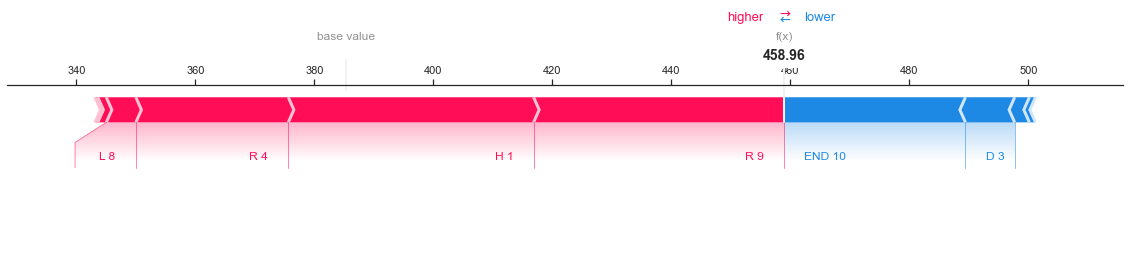

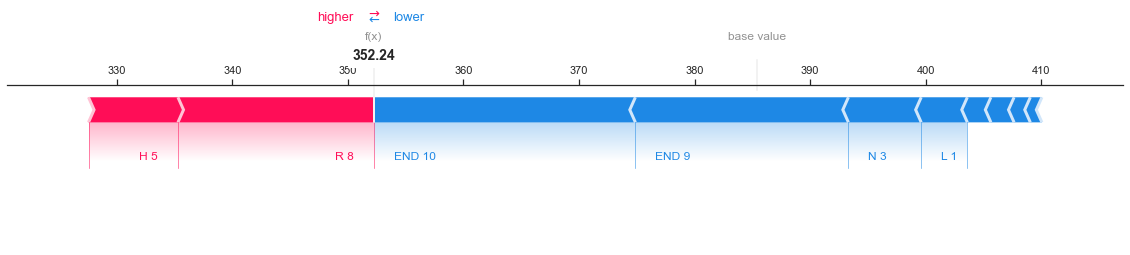

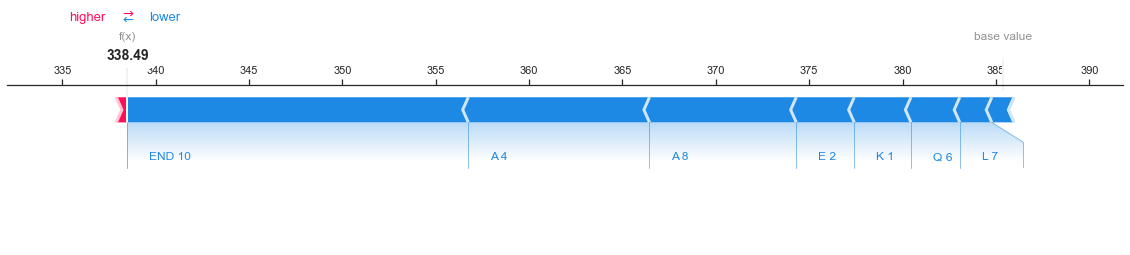

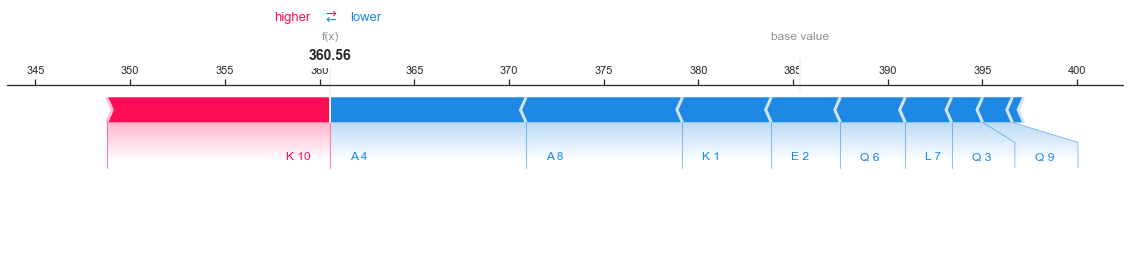

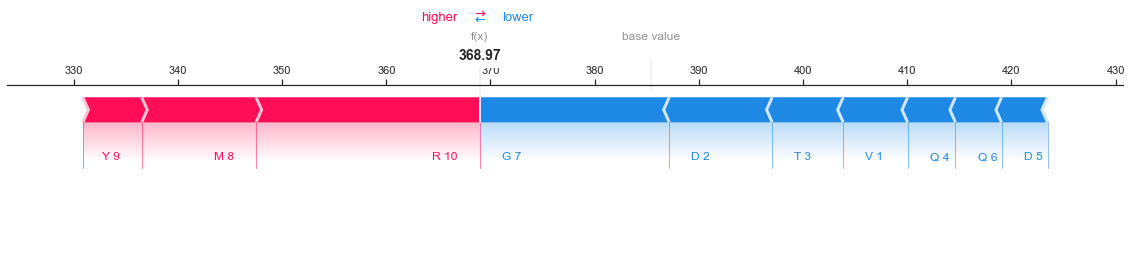

In [10]:
# init the JS visualization code
shap.initjs()

#Plot the forceplots of the SHAP values for the defined allele shap_values[n][i] (n = A001-0, A002-1, A008-2, B008-3, B017-4)

i = 0
while i < 5:
    savename = "CCS top-"
    plt.show()
    shap.force_plot(explainer.expected_value[0], shap_values[0][i], x_testpep[i], show=False, matplotlib=True)#.subplots_adjust(top = 2.5, bottom=1.5)
    savename = savename + str(i+1)
    #plt.savefig(savename+'.png', bbox_inches="tight")
    #plt.savefig(savename+'.svg', bbox_inches="tight")
    plt.show()
    i+=1

['R 1', 'L 2', 'A 3', 'H 4', 'C 5', 'E 6', 'E 7', 'L 8', 'R 9', 'END 10']


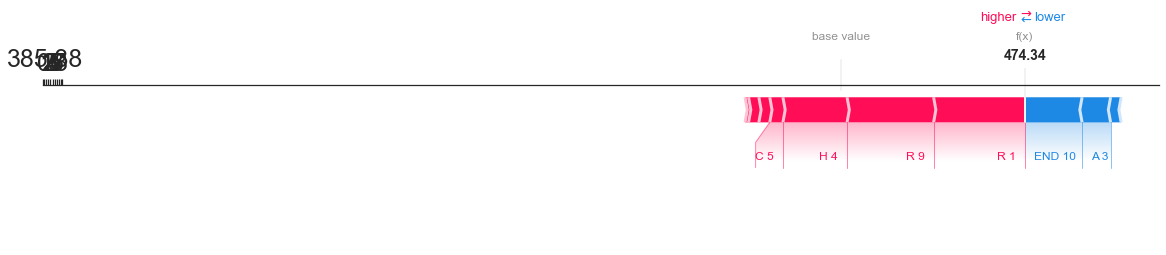

In [11]:
#Display forceplots for the top predicted peptide for each allele for the designated dataset (currently all)

savename = "CCS top predicted peptide"
plt.show()
plt.style.use('seaborn-ticks')
plt.rc('font', size=25)          # controls default text sizes
plt.rc('axes', titlesize=100)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=50)    # legend fontsize
plt.rc('figure', titlesize=50)
x = [-0.7,0,1,2,3,4,5,6,7,8,8.7]
xt = ['',0,1,2,3,4,5,6,7,8,'']




shap.force_plot(explainer.expected_value[0], shap_values[0][alla001i[0]], x_testpep[alla001i[0]], show=False, matplotlib=True)#.subplots_adjust(top = 2.5, bottom=1.5)
print(x_testpep[alla001i[0]])

plt.xticks(x,xt)
plt.text(0.5, 0.25, str(round(explainer.expected_value[0],2)), ha='center', va='center')
plt.savefig(savename+'.png', bbox_inches="tight")
plt.savefig(savename+'.svg', bbox_inches="tight")
plt.show()



In [80]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# create colormap by taking tab20 premade colormap and adding black to the bottom
upper = mpl.cm.tab20(np.arange(20))
lower = [0,0,0,1]
cmap1 = np.vstack(( lower, upper))

# convert to matplotlib colormap
cmap1 = mpl.colors.ListedColormap(cmap1, name='myColorMap', N=cmap1.shape[0])


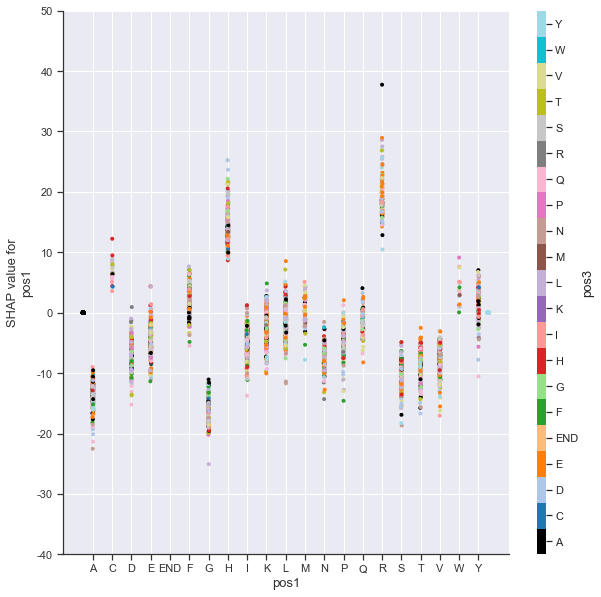

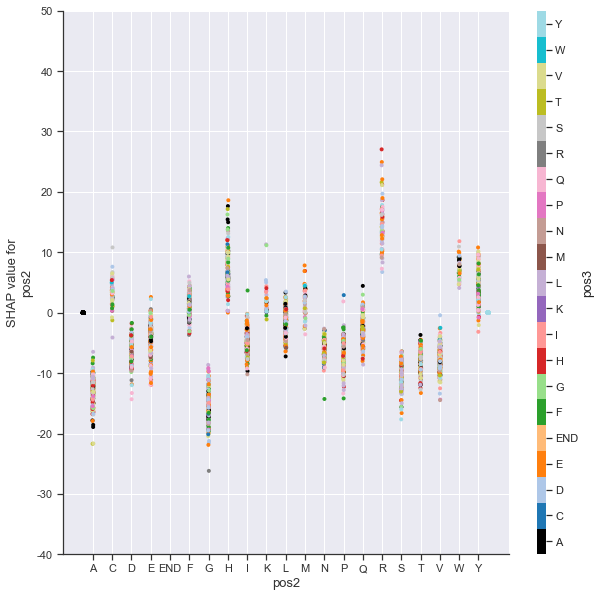

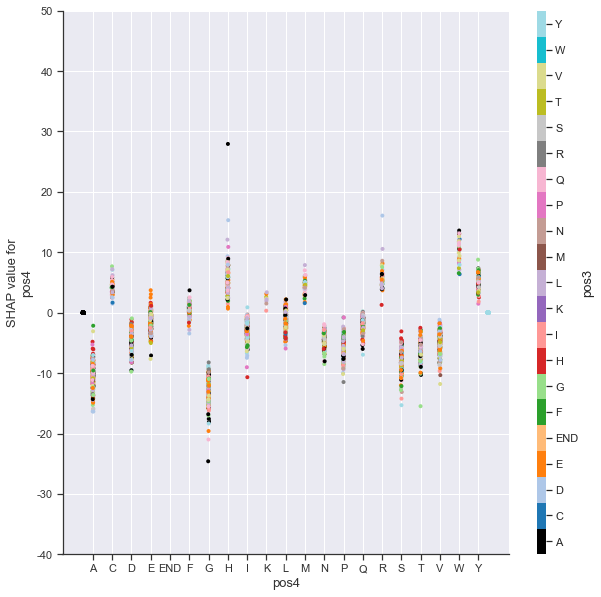

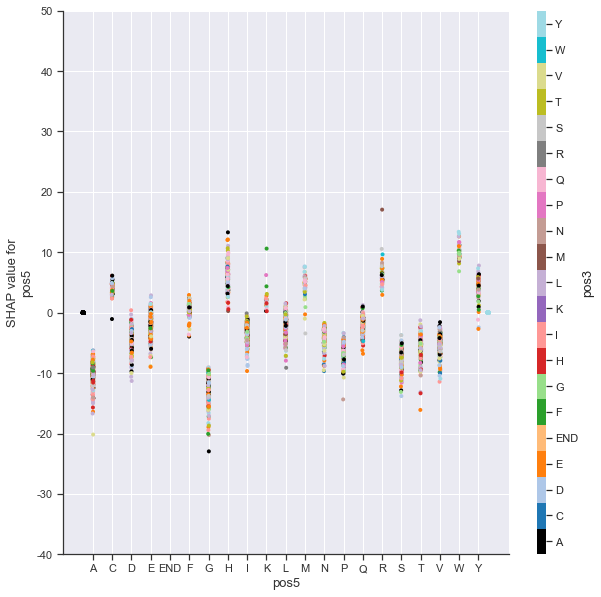

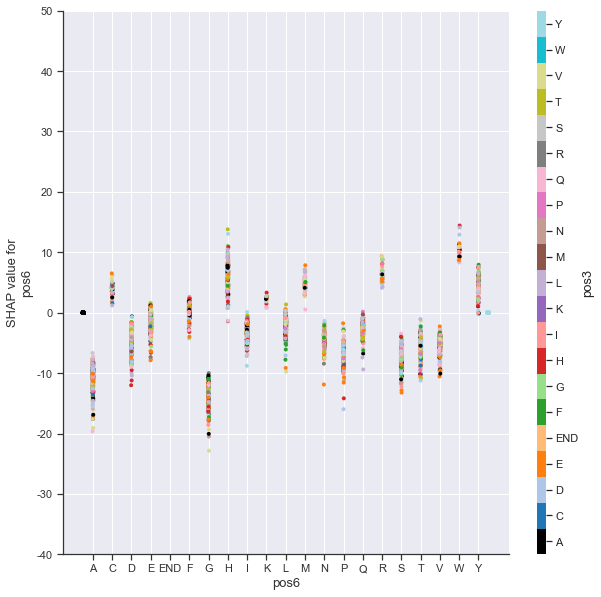

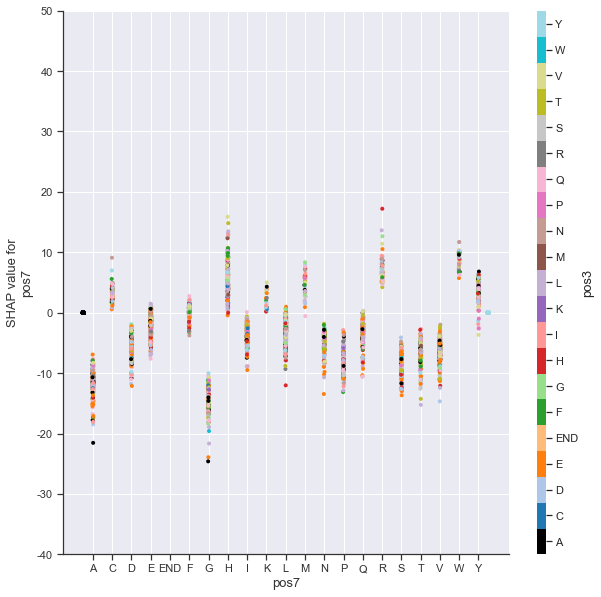

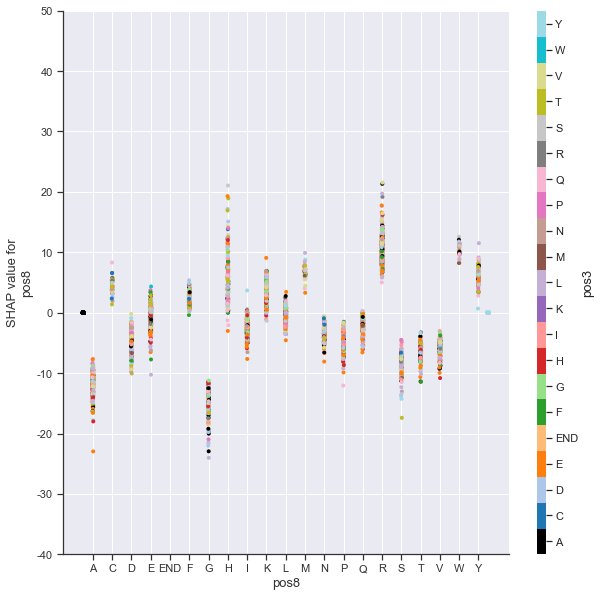

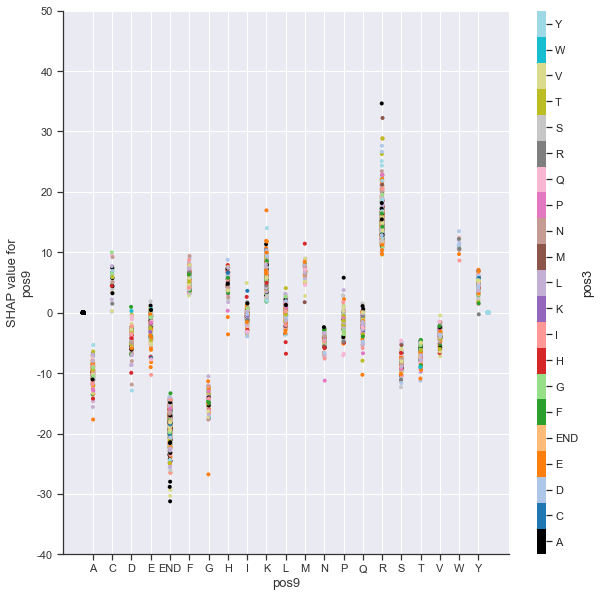

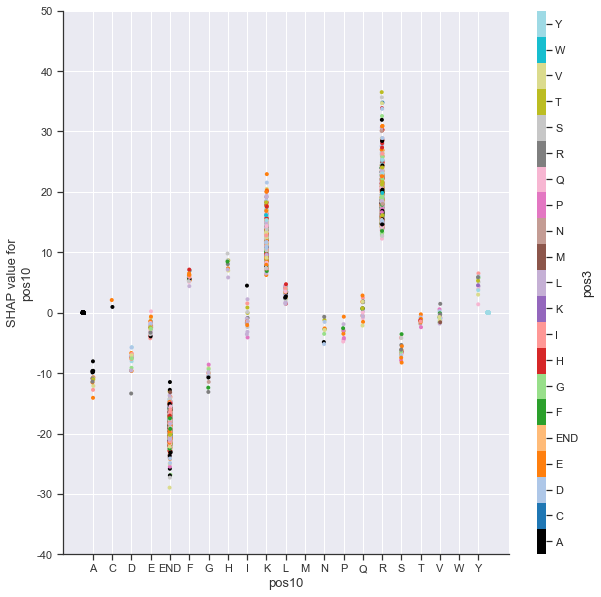

In [81]:
#Create Dependance plots for each of the positions shap.dependence_plot(a, shap_valuestmp[b], x_testadj, feature_names=['pos1', 'pos2', 'pos3','pos4', 'pos5', 'pos6','pos7', 'pos8', 'pos9','pos10'],  cmap=cmap1,show = False, x_jitter=.1,  interaction_index=c)
# a = position looking at
# b = allele looking at 
# c = position looking at interaction of i.e. colorbar
shap_values = shap_valuesall
x_test = x_testall
#Modify shap_values and data arrays to fix dependence_plot rounding on colorbar
shap_valuestmp = []

i = 0
while i<len(shap_values):
    j=0
    tmppeps = []
    while j < len (shap_values[i]):
        k=0
        tmpposs = []
        while k < len (shap_values[i][j]):
            tmpposs.append(shap_values[i][j][k])
            k+=1
        tmppeps.append(tmpposs)
        j+=1
    f=0
    #add 2000 blank shap values to make color bar right
    while f<2000:
        tmppeps.append([0,0,0,0,0,0,0,0,0,0])
        f+=1

    shap_valuestmp.append(tmppeps)
    
    i+=1
    
shap_valuestmp = np.array(shap_valuestmp)
i = 0
x_testadj = []

while i < len(x_test):
    tmp = []
    for value in x_test[i]:
        tmp.append(value)
    x_testadj.append(tmp)
    i+=1
i = 0
while i<1000:    
    x_testadj.append([-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5])
    i+=1
i = 0
while i<1000:
    x_testadj.append([20.5,20.5,20.5,20.5,20.5,20.5,20.5,20.5,20.5,20.5])
    
    i+=1
x_testadj = np.array(x_testadj)

y = [-40,-30,-20,-10,0,10,20,30,40,50]
yt = [-40,-30,-20,-10,0,10,20,30,40,50]
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
xt = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']


pos = 0

#set to allele index
allele = 0

#set to 'static', 'preceding', 'following'
compareto = 'static'
compared = 2


while pos < 10:
    
    if compareto == 'preceding':
        if pos == 0:
            compared = 9
        else:
            compared = pos-1
            
    if compareto == 'following':
        if pos == 9:
            compared = 0
        else:
            compared = pos+1
    if pos != compared:
        
        
    
        shap.dependence_plot(pos, shap_valuestmp[allele], x_testadj, feature_names=['pos1', 'pos2', 'pos3','pos4', 'pos5', 'pos6','pos7', 'pos8', 'pos9','pos10'],  cmap=cmap1, show = False, x_jitter=.1,  interaction_index=compared)
        plt.yticks(y,yt)
        plt.xticks(x,xt)

        fig = plt.gcf()
        fig.set_size_inches(10,10)
        #plt.set_clim(0,1)
        #plt.figure(figsize=(20, 10))
        cbs = []

        for ax in fig.axes:
            cbs.extend(ax.findobj(lambda obj: hasattr(obj, "colorbar") and obj.colorbar))

        colorb = cbs[0].colorbar
        #colorb.set_clim(-1, 21)
        z = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
        zt = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

        colorb.set_ticks(z)
        colorb.set_ticklabels(zt)
        #ax = plt.gca()
        #imshowobj = plt.imshow(x_testadj)
        #cbarobj = plt.colorbar(imshowobj, cmap=cmap1, ax= fig.axes[-1])
        #imshowobj.set_clim(0,20)

        #plt.savefig('dependenceplotnew' + str(pos) + '.svg', bbox_inches="tight", format = 'svg', dpi=1000)
        plt.show()
    
    pos+=1





<AxesSubplot:ylabel='Count'>

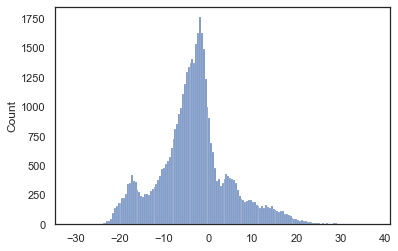

In [90]:
allshaps = []
i = 0

while i < len(shap_values[0]):
    j = 0
    while j < len(shap_values[0][i]):
        allshaps.append(shap_values[0][i][j])
        j+=1
    i+=1
    
import scipy
scipy.stats.normaltest(allshaps)

sns.histplot(data=allshaps)

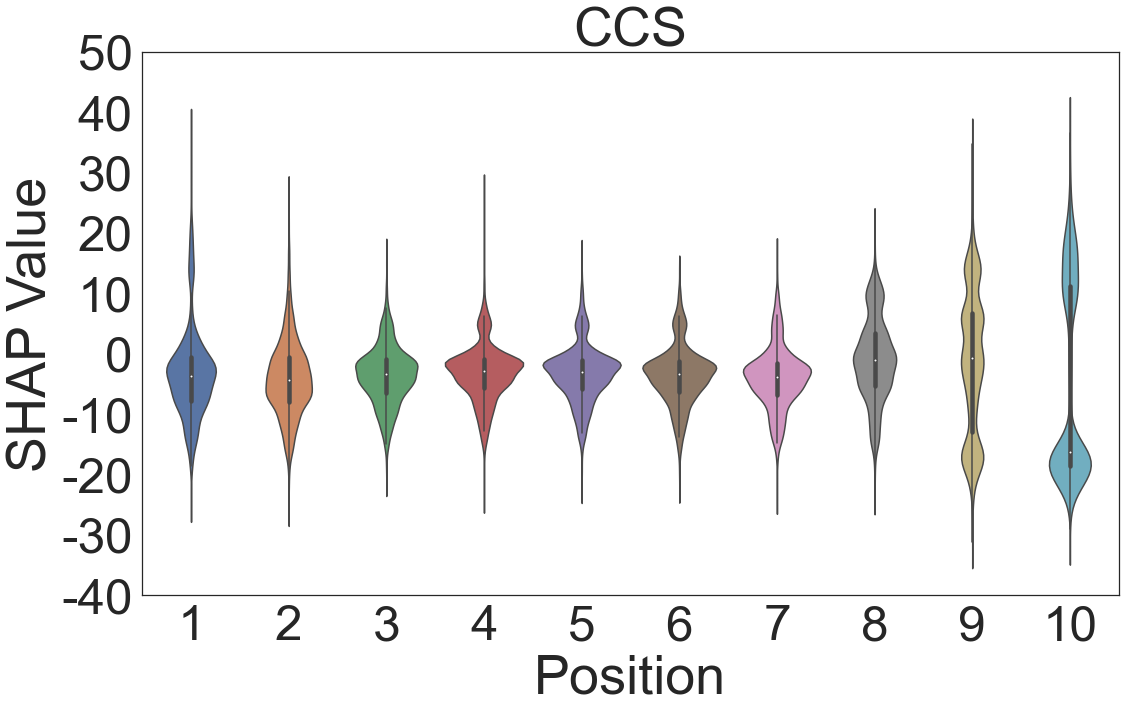

In [91]:
#shap values by position
shap_values = shap_valuesall
x_test = x_testall
positionalshaps = [[],[],[],[],[],[],[],[],[],[]]
i = 0
sns.set_style("white")
while i < len(shap_values[0]):
    j = 0
    while j < len(shap_values[0][i]):
        positionalshaps[j].append(shap_values[0][i][j])
        j+=1
    i+=1
    
sns.violinplot(data=positionalshaps)
fig = plt.gcf()
fig.set_size_inches(17.5,10)
plt.xlabel("Position")
plt.ylabel("SHAP Value")
plt.title("CCS")
sns.set(font_scale = 4.5)
plt.yticks(y,yt)
plt.xticks([0,1,2,3,4,5,6,7,8,9],["1" ,"2" ,"3","4","5","6","7","8","9","10"])
plt.savefig("positionSHAPrangeCCS-10mers.svg")
plt.show()

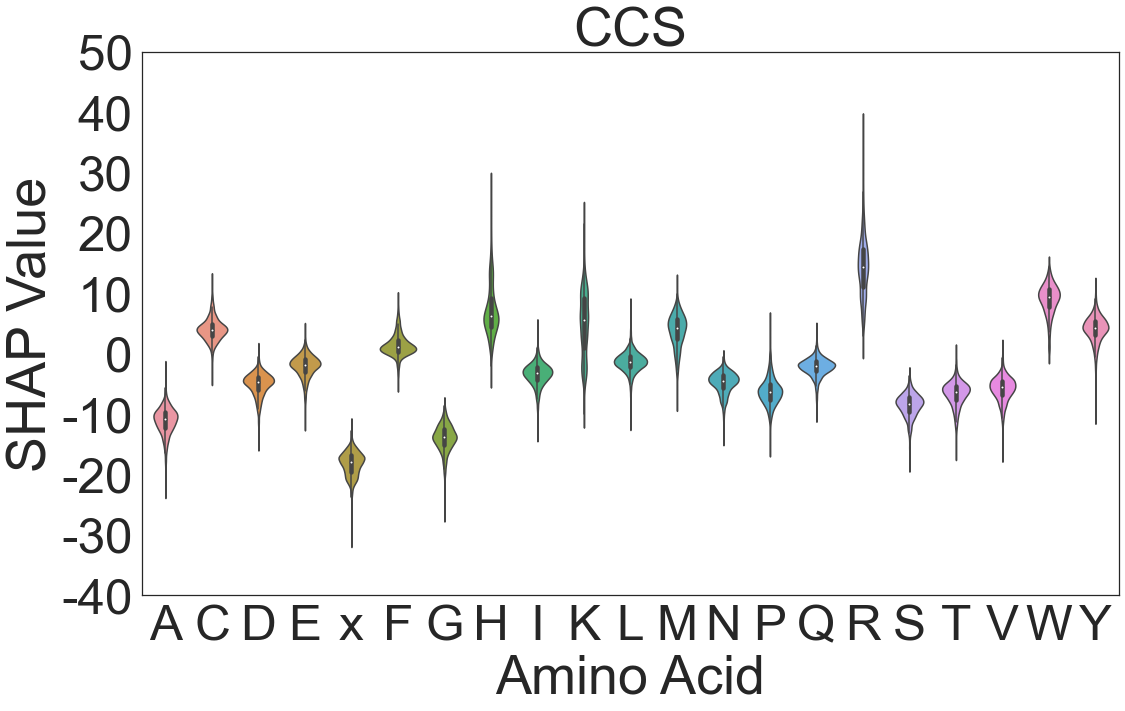

In [89]:
#shap values by amino acid
shap_values = shap_valuesall
x_test = x_testall
char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
aminoacidshaps = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
i=0
while i < len(shap_values[0]):
    j = 0
    while j < len(shap_values[0][i]):
        aminoacidshaps[int(x_test[i][j])].append(shap_values[0][i][j])
        j+=1
    i+=1
xt = ['A','C','D','E','x','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
sns.set_style("white")
sns.violinplot(data=aminoacidshaps)
plt.yticks(y,yt)
plt.xticks(x,xt)
plt.xlabel("Amino Acid")
plt.ylabel("SHAP Value")
plt.title("CCS")
sns.set(font_scale = 4.5)

fig = plt.gcf()
fig.set_size_inches(17.5,10)
plt.savefig("aminoacidSHAPrangeCCS10mers.svg")
plt.show()

In [381]:
#dependence analysis
import copy
shap_values = shap_valuesall
x_test = x_testall
aa = []

i = 0
j = 0
while i < 10:
    aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i = 0
j = 0


char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']


i=0
j=0
k=0


#through the positions
while (i < len(shap_values[0][0])):
    j=0
    shappostmp = []
    #through the values
    while (j < 21):
        #through the list
        k = 0
        while (k < len(shap_values[0])):
            #place each shap value corresponding to an amino acid into a new array
            if j == x_test[k][i]:
                aa[i][j].append(shap_values[0][k][i])
                
            k+=1
        j+=1
    i+=1
    
i = 0
j = 0


aadep = []

i = 0
j = 0
while i < 10:
    aadep.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i = 0
j = 0
temp = []
while i < len(shap_values[0][0]):
    temp.append(copy.deepcopy(aadep))
    i+=1
i = 0
deparray = []

while i < 21:
    deparray.append(copy.deepcopy(temp))
    i+=1
    
    
    
compaadep = []

i = 0
j = 0
while i < 10:
    compaadep.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i = 0
j = 0
comptemp = []
while i < len(shap_values[0][0]):
    comptemp.append(copy.deepcopy(compaadep))
    i+=1
i = 0
compdeparray = []

while i < 21:
    compdeparray.append(copy.deepcopy(comptemp))
    i+=1
    


char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']


i=0
j=0
k=0
a = 0
b = 0
#through the amino acids
while (a<21):
    b=0
    while (b < len(shap_values[0][0])):
        #through the positions
        i=0
        while (i < len(shap_values[0][0])):
            j=0
            
            #through the values
            if (b != i):
                #print("b!=i")
                #print(b)
                while (j < 21):
                    #through the list
                    k = 0
                    while (k < len(shap_values[0])):
                        #place each shap value corresponding to an amino acid into a new array
                        if j == x_test[k][i] and x_test[k][b] == a:
                            deparray[a][b][i][j].append(shap_values[0][k][i])
                        if j == x_test[k][i] and x_test[k][b] != a:
                            compdeparray[a][b][i][j].append(shap_values[0][k][i])
                        
                        k+=1
                    j+=1
            i+=1
        b+=1
    a+=1

    i = 0
j = 0
    
        

print(deparray[1][0][0])
print(compdeparray[0][0][0])
    
a = 0
b = 0
c = 0
d = 0



[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


In [389]:
print(deparray[0][3][0])
print(compdeparray[0][3][0])

[[0.0, -12.171830695636643, -10.827243782219753, -14.431169159057745, -15.642702887197398, -11.942409610480677, -12.971452994394054, -12.221930624182315, -12.64135654749468, -11.708575405542604, -11.717036962045615, -11.921855341416247], [0.0, 6.616051750178818, 6.689369178560253], [0.0, -5.136923157778959, -7.994128900097378, -9.124342422729779, -11.066358954484034, -8.348502790425565, -8.139585518759613, -7.7040882215008875, -6.225358715401712, -7.478430310298073, -7.667017000450397, -6.089361315947379, -9.728301584098466, -6.579838439211061, -6.114193653933389, -9.08973747306362, -7.2218587427074015, -7.1039677439475915, -7.007176455952275, -7.461827926688481], [0.0, -5.415568117190468, -3.3857543008166684, -3.8552331283254064, -6.617576312243892, -3.915654444133792, -2.8471948201569104, -6.038352317146978, -1.5150899500352861, -5.816677094721126, -6.734090617180886, -2.2215363747531884, -4.659562315541365, -5.373212668822111, -4.600481610449116, -5.442894786172906, -3.6527631992462

In [382]:
outputarray = []
char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
a = 0
b = 0
c = 0
d = 0
e = 0
lowest = 100
while a < len(deparray):
    b = 0
    while b < len(deparray[a]):
        c = 0
        while c<len(deparray[a][b]):
            d = 0
            while d < len(deparray[a][b][c]):
                stat,test = st.ttest_ind(deparray[a][b][c][d][1:], compdeparray[a][b][c][d][1:])
                stat,testmw = st.mannwhitneyu(deparray[a][b][c][d][1:], compdeparray[a][b][c][d][1:])
                if test<1:
                    if test < lowest:
                        lowest = test
                        besta = a
                        bestb = b
                        bestc = c
                        bestd = d
                    outputarray.append([test,testmw,char_index[a],b+1,c+1,char_index[d],len(deparray[a][b][c][d][1:]),len(compdeparray[a][b][c][d][1:]),np.mean(deparray[a][b][c][d][1:]),np.mean(compdeparray[a][b][c][d][1:]),abs(np.mean(compdeparray[a][b][c][d][1:])-np.mean(deparray[a][b][c][d][1:]))])
                    e+=1
                d+=1
            c+=1
        b+=1
    a+=1
print (e)
print (lowest)
print(besta)
print(bestb)
print(bestc)
print(bestd)



outputdf = pd.DataFrame(outputarray, columns = ["ttest pvalue", "mw pvalue", "compared amino acid", "compared position", "position", "amino acid","compared size","total size", "compared mean", "total mean", "abs difference"]) 
corrttest = outputdf["ttest pvalue"]*len(outputdf)
outputdf.insert(1, "corr ttest pvalue", corrttest)
corrmwtest = outputdf["mw pvalue"]*len(outputdf)
outputdf.insert(3, "corr mw pvalue", corrmwtest)
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#outputdf.sort_values(by='corr ttest pvalue', ascending=True)

divide by zero encountered in double_scalars
Degrees of freedom <= 0 for slice
invalid value encountered in double_scalars


25575
0.0
4
8
9
4


In [383]:

outputdf

,ttest pvalue,corr ttest pvalue,mw pvalue,corr mw pvalue,compared amino acid,compared position,position,amino acid,compared size,total size,compared mean,total mean,abs difference
0,0.424043,10844.902844,0.241938,6187.564425,A,1,2,A,24,261,-12.269193,-12.624259,0.355066
1,0.423939,10842.241416,0.126897,3245.391363,A,1,2,C,3,62,2.436274,3.485756,1.049482
2,0.254015,6496.430756,0.119650,3060.048135,A,1,2,D,13,236,-5.787099,-6.354564,0.567464
3,0.611396,15636.463089,0.056835,1453.548751,A,1,2,E,24,392,-4.164921,-3.941097,0.223825
4,0.055760,1426.074306,0.025474,651.492792,A,1,2,F,7,263,0.322873,1.401946,1.079074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25570,0.095215,2435.115341,0.045735,1169.665478,Y,10,8,I,2,230,-0.912550,-2.502516,1.589966
25571,0.397904,10176.384644,0.123302,3153.444382,Y,10,8,Q,2,230,-1.605082,-2.333937,0.728855
25572,0.564822,14445.320075,0.232093,5935.777767,Y,10,9,I,2,124,-1.107420,-0.575219,0.532201
25573,0.915537,23414.869994,0.361858,9254.523359,Y,10,9,L,2,293,0.225628,0.320548,0.094920


In [31]:
outputdf.to_csv('ccsdepanalysisfinal.csv',index=False)

,ttest pvalue,corr ttest pvalue,mw pvalue,corr mw pvalue,compared amino acid,compared position,position,amino acid,compared size,total size,compared mean,total mean,abs difference
0,0.424043,10844.902844,0.241938,6187.564425,A,1,2,A,24,261,-12.269193,-12.624259,0.355066
1,0.423939,10842.241416,0.126897,3245.391363,A,1,2,C,3,62,2.436274,3.485756,1.049482
2,0.254015,6496.430756,0.119650,3060.048135,A,1,2,D,13,236,-5.787099,-6.354564,0.567464
3,0.611396,15636.463089,0.056835,1453.548751,A,1,2,E,24,392,-4.164921,-3.941097,0.223825
4,0.055760,1426.074306,0.025474,651.492792,A,1,2,F,7,263,0.322873,1.401946,1.079074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25570,0.095215,2435.115341,0.045735,1169.665478,Y,10,8,I,2,230,-0.912550,-2.502516,1.589966
25571,0.397904,10176.384644,0.123302,3153.444382,Y,10,8,Q,2,230,-1.605082,-2.333937,0.728855
25572,0.564822,14445.320075,0.232093,5935.777767,Y,10,9,I,2,124,-1.107420,-0.575219,0.532201
25573,0.915537,23414.869994,0.361858,9254.523359,Y,10,9,L,2,293,0.225628,0.320548,0.094920


In [322]:

############################

outputdf = pd.read_csv('supptable3-ccsdepanalysis.csv')

In [323]:
import statsmodels
fdr = statsmodels.stats.multitest.multipletests(outputdf['mw pvalue'].tolist(), alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)


In [324]:
print(fdr)

(array([False, False, False, ..., False, False, False]), array([1., 1., 1., ..., 1., 1., 1.]), 2.0056008973590167e-06, 1.955034213098729e-06)


In [325]:
outputdf["corr mw pvalue"] = fdr[1]

In [326]:
posdiff = abs(outputdf['position']-outputdf['compared position'])
outputdf['distance']=posdiff

In [327]:
sigoutputdf =outputdf.loc[outputdf['corr mw pvalue'] <= 0.05]
#sigoutputdf =outputdf.loc[outputdf['corr mw pvalue'] <= 0.05]

In [328]:
sigoutputdf['Close'] = ['Neighbor' if x==1 else 'Near' if 2<=x<6 else 'Far' for x in sigoutputdf['distance']]
sigoutputdf


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ttest pvalue,corr ttest pvalue,mw pvalue,corr mw pvalue,compared amino acid,compared position,position,amino acid,compared size,total size,compared mean,total mean,abs difference,distance,Close
119,7.493178e-07,1.916380e-02,9.947970e-07,2.544193e-02,A,1,8,R,29,569,12.099879,10.205019,1.894860,7,Far
341,2.243714e-06,5.738299e-02,1.084220e-06,2.772893e-02,A,3,4,E,50,565,-2.189915,-1.367704,0.822211,1,Neighbor
1246,3.011124e-11,7.700950e-07,3.100815e-13,7.930334e-09,A,8,10,END,101,2513,-17.186122,-18.465987,1.279865,2,Near
2231,4.862336e-09,1.243542e-04,1.451787e-09,3.712946e-05,C,8,10,END,22,2592,-16.056807,-18.436564,2.379757,2,Near
3770,1.415230e-07,3.619450e-03,9.853428e-07,2.520014e-02,E,1,2,T,18,198,-9.981013,-7.770067,2.210946,1,Neighbor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24303,3.018189e-10,7.719018e-06,1.647439e-06,4.213326e-02,Y,1,2,Q,9,249,1.219741,-2.777896,3.997637,1,Neighbor
24439,6.119171e-07,1.564978e-02,8.712526e-07,2.228228e-02,Y,2,1,K,29,619,-4.151583,-2.332994,1.818589,1,Neighbor
24442,2.737248e-09,7.000512e-05,3.599601e-08,9.205978e-04,Y,2,1,P,13,161,-1.462522,-5.394719,3.932197,1,Neighbor
24558,2.013883e-09,5.150505e-05,1.097353e-11,2.806481e-07,Y,2,9,END,57,985,-16.145196,-17.944027,1.798831,7,Far


In [329]:
sigoutputdf['log abs difference'] = np.log(sigoutputdf['abs difference'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


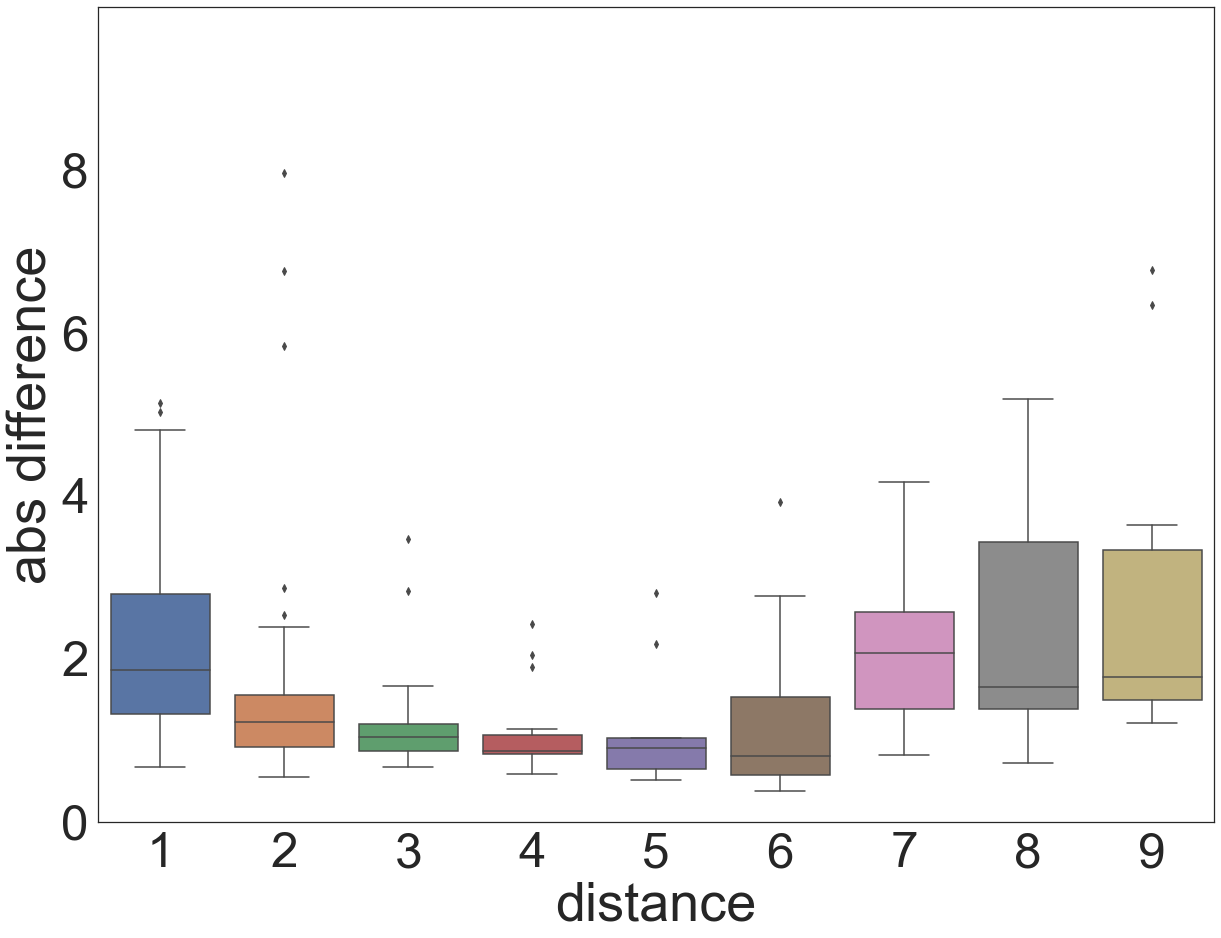

In [368]:
sns.set_style("white") 
sns.set(style="white", color_codes=True, font_scale=4.5)
a = sns.boxplot(x='distance', y= 'abs difference', data=sigoutputdf)#,  bw=.17)
#a.set_yscale("log")
fig = plt.gcf()
fig.set_size_inches(20,15)
plt.yticks([0,2,4,6,8, 10] , ["0",'2','4','6','8',''])
plt.savefig("rangeCCSinteractionsdistanceMW.svg")
plt.show()

In [331]:
import scipy
print(scipy.stats.levene(sigoutputdf.query("Close == 'Neighbor'")['abs difference'].tolist(),sigoutputdf.query("Close == 'Near'")['abs difference'].tolist(),sigoutputdf.query("Close == 'Far'")['abs difference'].tolist()))
print(scipy.stats.f_oneway(sigoutputdf.query("Close == 'Neighbor'")['abs difference'].tolist(),sigoutputdf.query("Close == 'Near'")['abs difference'].tolist(),sigoutputdf.query("Close == 'Far'")['abs difference'].tolist()))

LeveneResult(statistic=3.608979473361851, pvalue=0.02869478088727367)
F_onewayResult(statistic=10.710590321785471, pvalue=3.6408622649034363e-05)


In [332]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=sigoutputdf['abs difference'],
                          groups=sigoutputdf['Close'],
                          alpha=0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   Far     Near  -0.7816 0.001 -1.2539 -0.3093   True
   Far Neighbor  -0.0418   0.9 -0.5436  0.4601  False
  Near Neighbor   0.7398 0.001  0.2885  1.1912   True
-----------------------------------------------------


In [333]:
sigoutputdf = sigoutputdf.sort_values(by=['amino acid'], ascending = True)
diff = sigoutputdf['compared mean']-sigoutputdf['total mean']
sigoutputdf['difference']=diff
sigoutputdf

,ttest pvalue,corr ttest pvalue,mw pvalue,corr mw pvalue,compared amino acid,compared position,position,amino acid,compared size,total size,compared mean,total mean,abs difference,distance,Close,log abs difference,difference
11730,2.886213e-09,7.381490e-05,1.011420e-10,2.586706e-06,K,9,8,A,47,216,-10.138893,-11.874313,1.735420,1,Neighbor,0.551250,1.735420
5616,2.239799e-06,5.728286e-02,2.976285e-07,7.611849e-03,END,10,8,A,101,162,-10.885192,-11.987502,1.102310,2,Near,0.097408,1.102310
19494,2.031913e-08,5.196618e-04,5.178423e-10,1.324382e-05,R,10,9,A,65,91,-11.078480,-9.539492,1.538988,1,Neighbor,0.431125,-1.538988
19475,2.114779e-12,5.408548e-08,7.848932e-14,2.007364e-09,R,10,8,A,81,182,-12.728060,-11.046191,1.681869,2,Near,0.519905,-1.681869
11451,1.273031e-07,3.255778e-03,2.692644e-08,6.886437e-04,K,8,1,D,32,226,-5.251772,-7.490367,2.238595,7,Far,0.805848,2.238595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19155,1.950848e-07,4.989294e-03,1.349057e-08,3.450213e-04,R,8,7,V,50,248,-5.018299,-6.417725,1.399426,1,Neighbor,0.336062,1.399426
5633,2.376753e-07,6.078545e-03,9.929141e-08,2.539378e-03,END,10,8,V,109,131,-5.432425,-6.250188,0.817764,2,Near,-0.201182,0.817764
11108,2.159497e-05,5.522915e-01,1.449585e-06,3.707314e-02,K,1,2,Y,29,167,2.596981,4.706687,2.109707,1,Neighbor,0.746549,-2.109707
19157,3.168856e-05,8.104349e-01,8.901343e-07,2.276518e-02,R,8,7,Y,19,117,4.948518,3.170378,1.778140,1,Neighbor,0.575568,1.778140


In [334]:
sigoutputdf['compared amino acid category'] = ['Positive' if (x== "R" or x == "H" or x == "K")  else 'Negative' if (x== "D" or x == "E") else 'Polar' if (x== "S" or x == "T" or x == "N" or x == "Q") else 'Special' if (x== "C" or x == "G" or x == "P") else 'End' if (x=='END')  else 'Hydrophobic' for x in sigoutputdf['compared amino acid']]

sigoutputdf['amino acid category'] = ['Positive' if (x== "R" or x == "H" or x == "K")  else 'Negative' if (x== "D" or x == "E") else 'Polar' if (x== "S" or x == "T" or x == "N" or x == "Q") else 'End' if (x=='END')  else 'Hydrophobic' for x in sigoutputdf['amino acid']]

interactiontype = []
interactiontypecategory = []
i = 0
while i < len(sigoutputdf['amino acid category'].tolist()):
    if sigoutputdf['amino acid category'].tolist()[i] == 'Positive':
        if sigoutputdf['compared amino acid category'].tolist()[i] == 'Positive':
            interactiontype.append('Charge Repulsion')
            interactiontypecategory.append("Repulsive")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'Negative':
            interactiontype.append('Charge Attraction')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'Polar':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'End':
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
        else:
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
    elif sigoutputdf['amino acid category'].tolist()[i] == 'Negative':
        if sigoutputdf['compared amino acid category'].tolist()[i] == 'Positive':
            interactiontype.append('Charge Attraction')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'Negative':
            interactiontype.append('Charge Repulsion')
            interactiontypecategory.append("Repulsive")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'Polar':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'End':
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
        else:
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
    elif sigoutputdf['amino acid category'].tolist()[i] == 'Polar':
        if sigoutputdf['compared amino acid category'].tolist()[i] == 'Positive':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'Negative':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'Polar':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'End':
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
        else:
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
    elif sigoutputdf['amino acid category'].tolist()[i] == 'Hydrophobic':
        if sigoutputdf['compared amino acid category'].tolist()[i] == 'Hydrophobic':
            interactiontype.append('Hydrophobic')
            interactiontypecategory.append("Attraction")
        elif sigoutputdf['compared amino acid category'].tolist()[i] == 'End':
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
        else:
            interactiontype.append('zOther')
            interactiontypecategory.append("Repulsive")
            
    elif sigoutputdf['amino acid category'].tolist()[i] == 'End':
        interactiontype.append('zOther')
        interactiontypecategory.append("Repulsive")
    else:
        interactiontype.append('zOther')
        interactiontypecategory.append("Repulsive")
    i+=1
            
print(len(sigoutputdf['compared amino acid category'].tolist()))          
print(len(sigoutputdf['amino acid category'].tolist()))      
print(len(interactiontype))


sigoutputdf['interaction type'] = interactiontype
sigoutputdf['interaction type category'] = interactiontypecategory

223
223
223


In [342]:
tempdf1 = sigoutputdf.copy()
tempdf2 = sigoutputdf.copy()

tempdf2["amino acid"] = tempdf2["compared amino acid"]

tempdf3 = pd.concat([tempdf1, tempdf2])

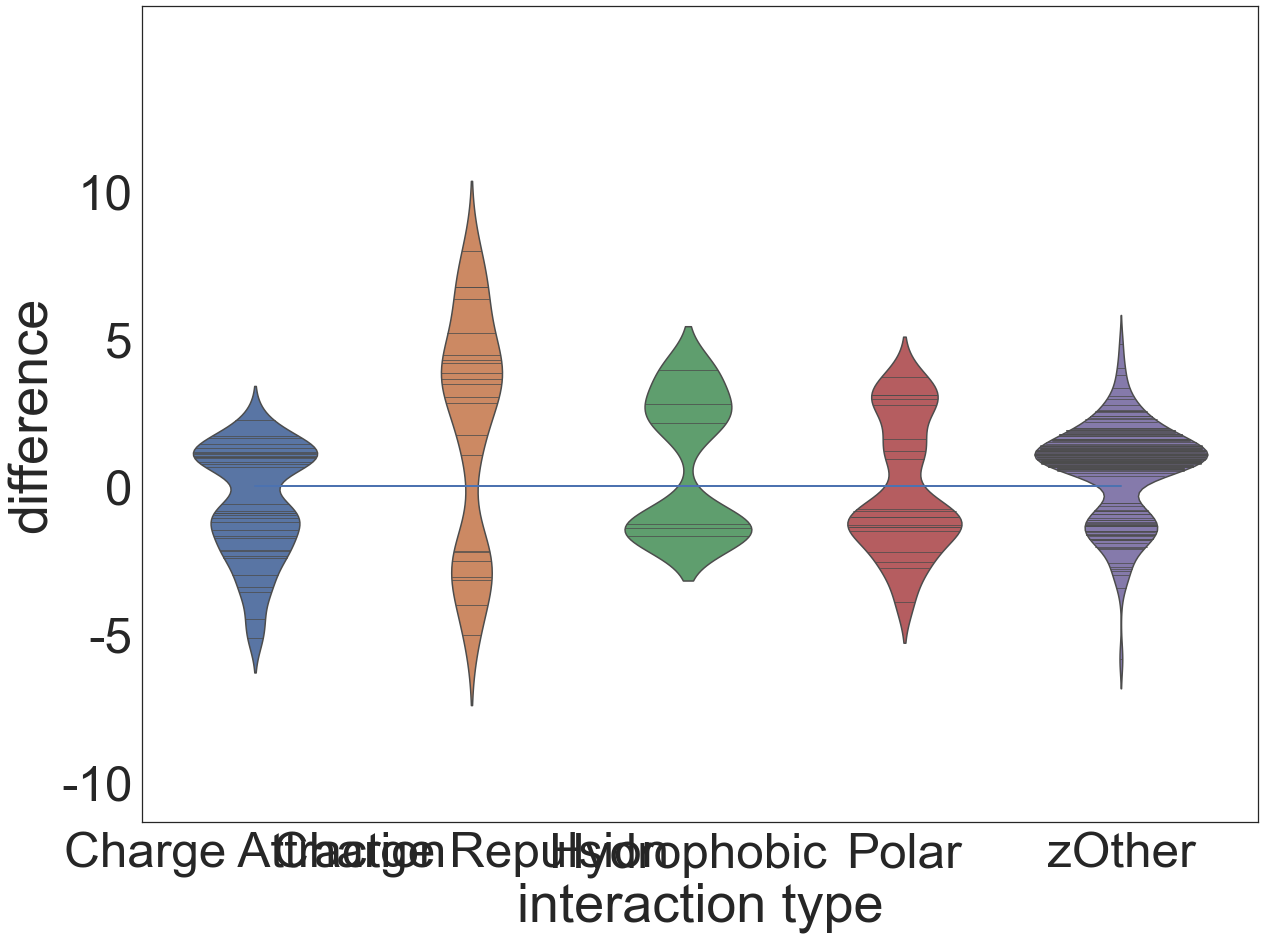

In [375]:
sigoutputdf = sigoutputdf.sort_values(by='interaction type')
sns.set(style="white", color_codes=True, font_scale=4.5)
a=sns.violinplot(x='interaction type', y= 'difference', data=sigoutputdf, inner="stick", bw=0.3)
#a.set_yscale("log")
fig = plt.gcf()
fig.set_size_inches(20,15)
a.set_yticks([-10,-5,0,5,10,20])
a.set_yticklabels(["-10",'-5','0','5','10', ''])
plt.yticks([-10,-5,0,5,10,20] , ["-10",'-5','0','5','10', ''])
plt.plot([0, 4], [0, 0], linewidth=2)
plt.plot([0, 0], [15, 15], linewidth=0)
plt.plot([0, 0], [-10.1, -10.1], linewidth=0)
plt.savefig("rangeCCSinteractionsaminoacid.svg")
plt.show()

In [345]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=tempdf3['difference'],
                          groups=tempdf3['amino acid'],
                          alpha=0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      C   2.0984    0.9  -6.2183 10.4152  False
     A      D   0.7421    0.9  -3.4163  4.9004  False
     A      E  -0.5385    0.9  -3.6947  2.6177  False
     A    END   0.2148    0.9  -2.8671  3.2968  False
     A      F   0.5441    0.9  -3.2897  4.3779  False
     A      G   1.2774    0.9  -3.5987  6.1535  False
     A      H   0.2546    0.9   -2.959  3.4682  False
     A      I   0.5107    0.9  -3.0147  4.0362  False
     A      K   0.2151    0.9  -2.8894  3.3197  False
     A      L  -0.1201    0.9  -3.2809  3.0408  False
     A      N    0.138    0.9  -3.8883  4.1643  False
     A      P   0.7206    0.9  -2.8048   4.246  False
     A      Q  -0.5817    0.9  -4.2816  3.1183  False
     A      R  -0.0315    0.9  -3.1027  3.0396  False
     A      S   0.6182    0.9  -3.9371  5.1734  False
     A      T   1.0012    0.

In [339]:
sigoutputdf['difference']
a = sigoutputdf.loc[sigoutputdf['interaction type category'] == 'Attraction', 'difference']

b = sigoutputdf.loc[sigoutputdf['interaction type category'] == 'Repulsive', 'difference']
print (np.mean(a.tolist()))
print (np.mean(b.tolist()))
stat,test = st.ttest_ind(a.tolist(), b.tolist())
stat,test = scipy.stats.mannwhitneyu(a.tolist(), b.tolist())

print (test)

-0.31362167629369087
0.6971856264456383
0.003519276918917807


In [23]:
sigoutputdf.to_csv('sigoutputdf_ccsdepanalysisfinal.csv',index=False)

In [35]:
#Start Making Heatmaps


#create array with zeros to hold shap values for each amino acid
aa = []
i = 0
while i < 10:
    aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1
#print (len(aa))
print (len(aa[0]))
print (aa)

21
[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.

In [15]:
char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
#create 3D array to keep track of amino acid position shap values
#Change 
#Change shap values index for each allele 0 = A001 1 = A002 2 = A008 3 = B008 4 = B017
i = 0

while i < len(peptidesallA001toppercent):
    j=0
    
    while j < len(peptidesallA001toppercent[i]):        
        aa[j][int(peptidesallA001toppercent[i][j])].append(shapvaluesallA001toppercent[0][i][j])  
        
        j+=1
    i+=1   

NameError: name 'peptidesallA001toppercent' is not defined

In [16]:
#HEATMAP MEAN
heatmap = []
i = 0
while i < len(aa):
    j=0
    heatmap.append([])
    while j < len(aa[i]):
        if len(aa[i][j]) > 1:
            
            heatmap[i].append((sum(aa[i][j])/float(len(aa[i][j])-1)))
        else:
            heatmap[i].append(0)
            
        j+=1
    i+=1 

In [19]:
# #HEATMAP SUM
# heatmap = []
# i = 0
# while i < len(aa):
#     j=0
#     heatmap.append([])
#     while j < len(aa[i]):
#         if len(aa[i][j]) > 1:
            
#             #print(char_index[j] + str(i+1) + ": ")
            
            
#             #print(str((sum(aa[i][j])/float(len(aa[i][j])-1))))
#             heatmap[i].append(sum(aa[i][j]))
#         else:
#             heatmap[i].append(0)
            
#             #print(char_index[j] + str(i+1) + ": ")
#             #print ("0")
#         j+=1
#     i+=1 
# heatmap = np.array(heatmap)

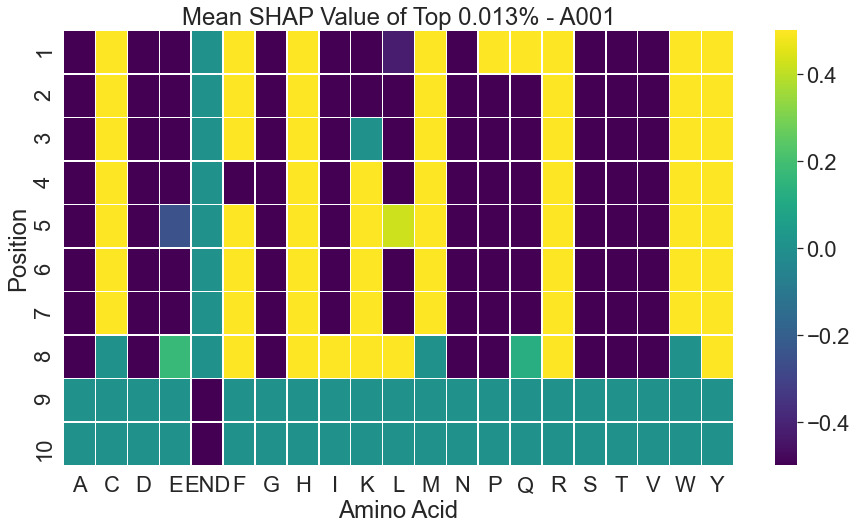

In [34]:
import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
x_axis_labels = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
y_axis_labels = ['1','2','3','4','5','6','7','8','9','10']
sns.set(font_scale=2)

# figure size in inches
rcParams['figure.figsize'] = 15,8

ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,linewidths=.5, vmin=-.5, vmax=.5, cmap="viridis")


ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean SHAP Value of Top 0.013% - A001')
#ax.figure.savefig('MeanSHAPvalA001-8mers.png')
ax.figure.savefig('MeanSHAPvalA001-4sigma.svg')
plt.show()

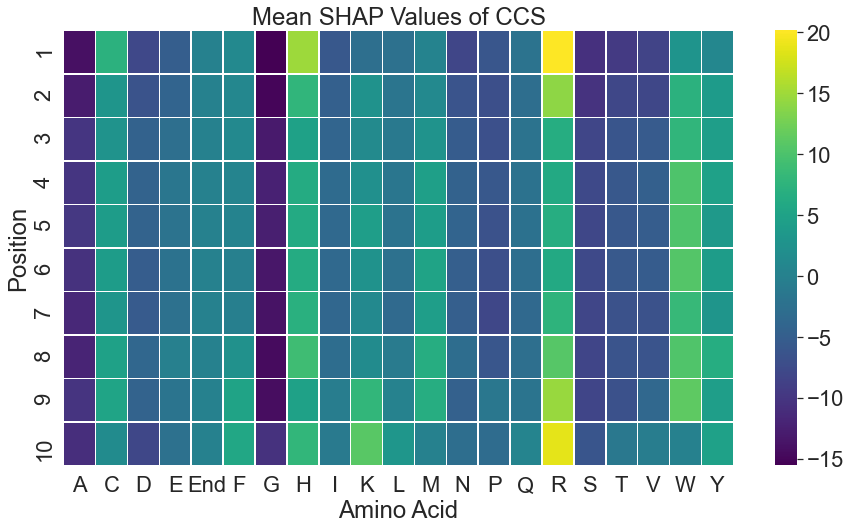

In [53]:
#Create Mean Heatmaps for all alleles

import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

#Change these three to match correct values

topbottom = "top"
merfile = "all"


x_testsubset = x_test9mers
shap_valuestmp = shap_values9mers






    
x = 0
    
    
char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

x_testpep = []
temppep = []
i = 0

while i < len(x_testsubset):
       
    j = 0
    while j < len(x_test[i]):
        #print(x_testsubset[i][j])
        #temppep.append(str(char_index[int(x_testsubset[i][j])] + " " + str(j+1)))
        temppep.append(str(char_index[int(x_testsubset[i][j])] + " " + str(j+1)))
        j+=1
    x_testpep.append(temppep)
    temppep = []
    i+=1
x_testsubset = x_test10mers
x_testpep = x_testpep
shap_valuestmp = shap_values10mers
shap_values = shap_values10mers

while x < 1:
    aa = []
    i = 0
    if x==0:
        figfilename='MeanSHAPValA001-'+merfile
        allelename = 'A001'
    if x==1:
        figfilename='MeanSHAPValA002-'+merfile
        allelename = 'A002'
    if x==2:
        figfilename='MeanSHAPValA008-'+merfile
        allelename = 'A008'
    if x==3:
        figfilename='MeanSHAPValB008-'+merfile
        allelename = 'B008'
    if x==4:
        figfilename='MeanSHAPValB017-'+merfile
        allelename = 'B017'
            
    i = 0
    while i < 10:
        aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
        i+=1

    char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    #create 3D array to keep track of amino acid position shap values
    #Change shap values index for each allele 0 = A001 1 = A002 2 = A008 3 = B008 4 = B017
    i = 0
    
    while i < len(x_testsubset):
        j=0

        while j < len(x_testsubset[i]):
            
            while True:
                try:
                    
                    
                    aa[j][int(x_testsubset[i][j])].append(shap_valuestmp[x][i][j])
                    break
                except IndexError:
                    print('j=' + str(j))
                    print('i=' + str(i))
                    print('x=' + str(x))
                    print('len of aa =' + str(len(aa)))
                    print('len of aa[j] =' + str(len(aa[0])))
                    print('len of x_testsubset' + str(len(x_testsubset)))
                    print('len of x_testsubset[i]' + str(len(x_testsubset[i])))
                    print('len of shap' + str(len(shap_valuestmp)))
                    print('len of shap[x]' + str(len(shap_valuestmp[x])))
                    print('shap[x]' + str(shap_valuestmp[x]))
                    print('len of shap[x][i]' + str(len(shap_valuestmp[x][i])))
              
            #print(str(i)+ " " + str(j) + " " + str(len(x_testsubset))+ " " + str(len(x_testsubset[i]))+ " " + str(x_testsubset[i][j]))
            
            j+=1
        i+=1  
    heatmap = []
    i = 0
    while i < len(aa):
        j=0
        heatmap.append([])
        while j < len(aa[i]):
            if len(aa[i][j]) > 1:

                #print(char_index[j] + str(i+1) + ": ")


                #print(str((sum(aa[i][j])/float(len(aa[i][j])-1))))
                
                #sum
                #heatmap[i].append((sum(aa[i][j])))
                
                
                #mean
                heatmap[i].append((sum(aa[i][j])/float(len(aa[i][j])-1)))
                
                #max
                #heatmap[i].append((np.array(aa[i][j]).max()))
                
                #stddev
                #heatmap[i].append((np.std(aa[i][j])))
                
                #stderr
                #heatmap[i].append((st.sem(aa[i][j])))
                               
                #count
                #heatmap[i].append((len(np.array(aa[i][j]))))
            else:
                heatmap[i].append(0)

                #print(char_index[j] + str(i+1) + ": ")
                #print ("0")
            j+=1
        i+=1
    heatmap = np.array(heatmap)
    
    
    #heatmap = (heatmap - heatmap.mean())/(heatmap.max()-heatmap.min())
    
    #normalize based off max
    #heatmap = heatmap/heatmap.max()
    
    #Log data
    #heatmap = np.log(heatmap+1)
   
    figfilename = figfilename
    #print (heatmap.max())
    #print (heatmap.min())
    
    plt.figure()
    x_axis_labels = ['A','C','D','E','End','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
    y_axis_labels = ['1','2','3','4','5','6','7','8','9','10']
    sns.set(font_scale=2)

    # figure size in inches
    rcParams['figure.figsize'] = 15,8

    ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,linewidths=.5,  cmap="viridis")


    ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean SHAP Values of CCS')
    ax.figure.savefig('ccs10mers.png')
    ax.figure.savefig('ccs10mers.svg')
    plt.show()
    x+=1